## RENTAL LISTINGS - EDA 

----------------------------------------------------

** by Ignacio Carracedo **

*February 2017 *

-------------------------------------------------

In this Kaggle competition, we will predict how popular an apartment rental listing is based on the listing content like text description, photos, number of bedrooms, price, etc. The data comes from renthop.com, an apartment listing website. These apartments are located in New York City.

The target variable, `interest_level`, is defined by the number of inquiries a listing has in the duration that the listing was live on the site. 

We will predict the number of inquiries a new listing receives based on the listing’s creation date and other features. Doing so will help RentHop better handle fraud control, identify potential listing quality issues, and allow owners and agents to better understand renters’ needs and preferences.

More info: https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries

This notebook explores the data, trying to understand it and along the way thinking about possible fixes (missing values, outliers) and posible feature engineering to improve the models.

### Imports and versions

The next two cells import all necessary libraries and shows the versions used

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,scikit-learn,seaborn

2017-02-23 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0
scikit-learn 0.18.1
seaborn 0.7.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


We load the data and check the columns and its types

In [3]:
train_df = pd.read_json("./input/train.json")
print(train_df.shape)
train_df.info()

(49352, 15)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


This notebook will explore each feature and its relation with the dependent variable `interest_level`. Furthermore, it will also explore how to transform variables into more useful ones.

Let's see how many missing values we have to start with

In [4]:
train_df.isnull().sum()

bathrooms          0
bedrooms           0
building_id        0
created            0
description        0
display_address    0
features           0
interest_level     0
latitude           0
listing_id         0
longitude          0
manager_id         0
photos             0
price              0
street_address     0
dtype: int64

Good news, no missing values! We'll make sure we look for outliers and check for observations with errors on each of the columns.

## interest_level     

`Interest_level` is our target variable. It has see levels (low, medium, and high). Let's check the count of each level.

In [5]:
train_df.interest_level.value_counts()   

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

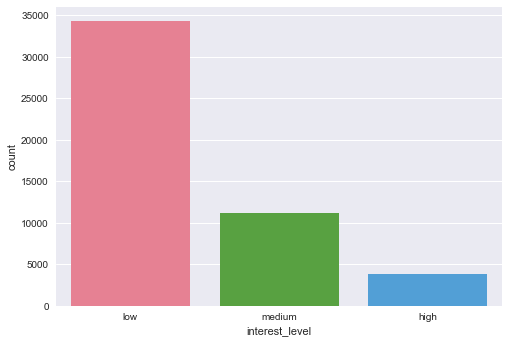

In [6]:
sns.countplot(x='interest_level',
              data=train_df, palette="husl",
              order =['low','medium','high'])
plt.show()

Classes are not balanced. We'll keep it in mind in case we want to do oversampling of some classes (high and medium)

## bathrooms

In [7]:
train_df['bathrooms'].value_counts()

1.0     39422
2.0      7660
3.0       745
1.5       645
0.0       313
2.5       277
4.0       159
3.5        70
4.5        29
5.0        20
5.5         5
6.0         4
10.0        1
6.5         1
7.0         1
Name: bathrooms, dtype: int64

Quite a few listings with 0 bathrooms, this could be an error, we'll check this later. First, let's visualize the feature bathroom:

* Total count
* Total count by interest
* Violin plot by interest
* Total count of listings having half bathrooms and not having them (by interest).

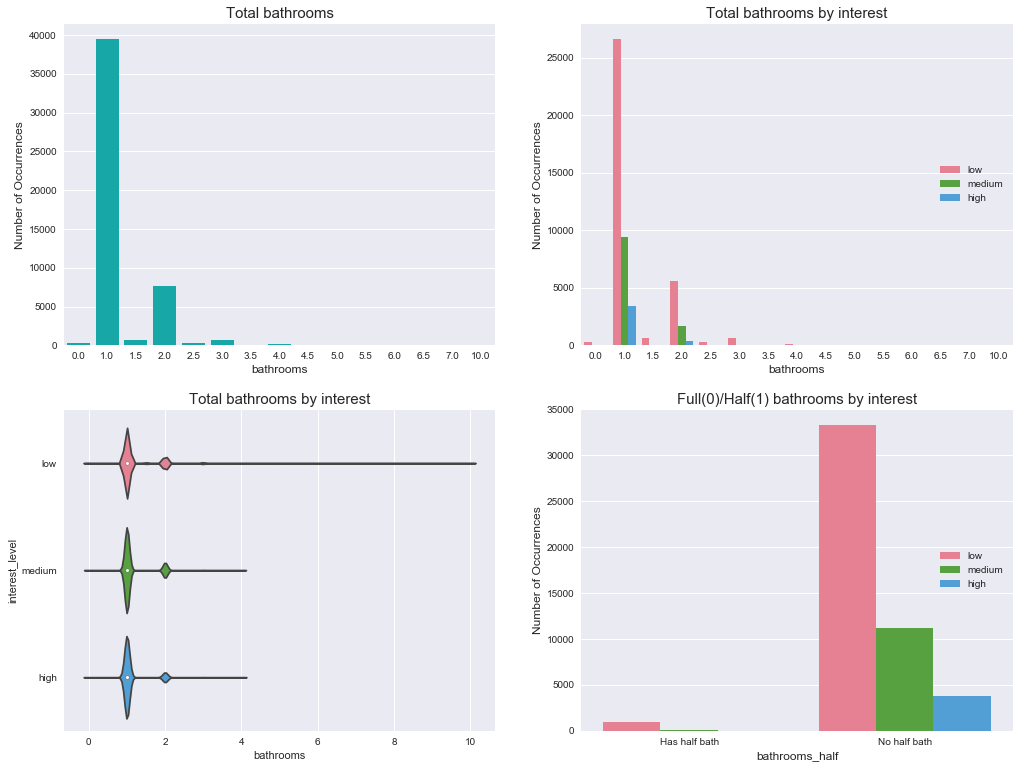

In [8]:
fig = plt.figure(figsize=(17,13))
# hist
fig.add_subplot(221)
sns.countplot(x='bathrooms',
              data=train_df, 
              color="c")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bathrooms', fontsize=12)
plt.title("Total bathrooms",fontsize=15)
# hist hue
fig.add_subplot(222)
sns.countplot(x='bathrooms',
              hue='interest_level',
              data=train_df,
              palette="husl",
              hue_order =['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bathrooms', fontsize=12)
plt.title("Total bathrooms by interest",fontsize=15)
plt.legend(loc='center right')
# violin
fig.add_subplot(223)
sns.violinplot(x='bathrooms',
               y='interest_level',
               data=train_df,
               palette="husl",
               order =['low','medium','high'])
plt.title("Total bathrooms by interest",fontsize=15)
# total, half 
train_df['half_bath'] = train_df['bathrooms'].map(lambda x:
                                                  "Has half bath"
                                                  if x%1 == 0.5
                                                  else "No half bath")
fig.add_subplot(224)
sns.countplot(x='half_bath',
              hue='interest_level',
              data=train_df,
              palette="husl",
              hue_order =['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bathrooms_half', fontsize=12)
plt.title("Full(0)/Half(1) bathrooms by interest",fontsize=15)
plt.legend(loc='center right')

plt.show()

Bathrooms seem evenly distributed across interest. Only low interest seem to have more than 4 bathrooms though. 

Also, there are more listings with full bathrooms that with half bathrooms, we'll add a variable showing if a listing has half bathrooms to test if that has any impact (no high interest with half bathrooms). See numbers for listings with half and full below (difficult to appreciate in the bar plot):

In [9]:
print("Listings with no half bathrooms:")
print(train_df[train_df.half_bath== "No half bath"]['interest_level'].value_counts())
print("\nListings with half bathrooms:")
print(train_df[train_df.half_bath== "Has half bath"]['interest_level'].value_counts())

Listings with no half bathrooms:
low       33300
medium    11186
high       3839
Name: interest_level, dtype: int64

Listings with half bathrooms:
low       984
medium     43
Name: interest_level, dtype: int64


As we said before, we noticed there are listings with 0 bathrooms, how can this be? Maybe they are sharing rooms? There is a `description` feature, we can look at that description to see if a bathroom is specified there. Let's create the data frame of rooms with no bathroom and explore it.

First, let's see how many bedrooms listings with no bathrooms have

In [10]:
no_bathroom = train_df[train_df.bathrooms == 0]
print(no_bathroom.shape)
no_bathroom.bedrooms.value_counts() # bedrooms on listings with 0 bathrooms

(313, 16)


0    157
1     73
2     59
3     21
4      3
Name: bedrooms, dtype: int64

Some listing have 0 bedrooms (studios) and some have bedrooms but no bathrooms.

Let's check the `description` for listings with zero bathrooms to see if you can find the string "bathroom". We'll show 20 characters before and after if the word "bathroom" is found, otherwise it will show an empty string

In [11]:
no_bathroom["description"] = no_bathroom["description"].str.lower()

output = no_bathroom.description.map(lambda x: x.partition("bath")[0][-20:] + 
                                     x.partition("bath")[1] + x.partition("bath")[2][:20] 
                                     if x.partition("bath")[1]!=""
                                     else "").value_counts().head(15)

print(output)
print("\nOutput trimmed to 15 lines ...")

                                                231
 city views, custom bathroom vanities with a     11
edroom, full marble bathroom, massive open c      5
r, laundry, updated bath and kitchen, live i      3
closet, a renovated bathroom with jacuzzi tu      3
ne countertops, and bathrooms dressed in fin      3
signer kitchens and bathrooms outfitted with      2
s new kitchens, new bathrooms and over-sized      2
ouse duplex-2 bed 2 bath-private roof deck 6      2
te kitchens, marble bathrooms, and fireplace      2
in closet, spa-like bathrooms and picture wi      2
 kitchen, limestone bath with kohler fixture      2
d sunny 2 bedroom 1 bathroom with separate e      2
bedroom with marble bath, restored original       2
nd three and a half bathrooms. thousand squa      2
Name: description, dtype: int64

Output trimmed to 15 lines ...


231 out of 313 listings with no bathroom don't have the word bath in their description. For the rest we could try to extract the  number of bathrooms from description but there aren't many listings so it may not be useful. We'll keep it in mind though.

## bedrooms

Let's explore the feature bedrooms next

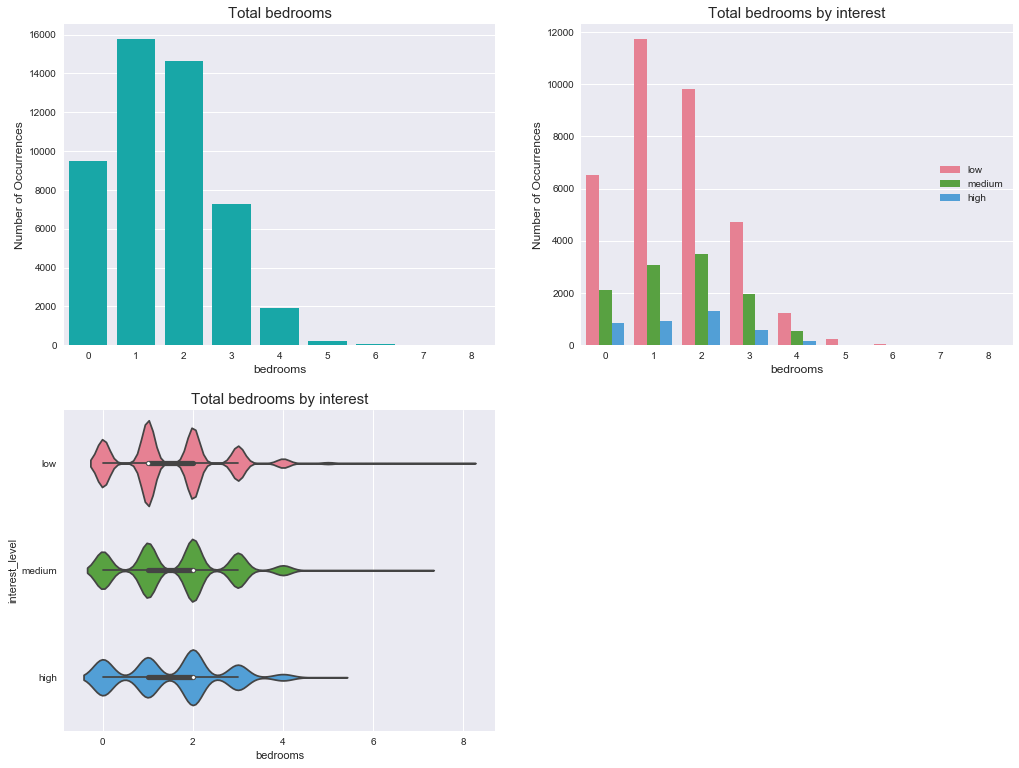

In [12]:
fig = plt.figure(figsize=(17,13))
# hist
fig.add_subplot(221)
sns.countplot(x='bedrooms',
              data=train_df,
              color="c")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bedrooms', fontsize=12)
plt.title("Total bedrooms",fontsize=15)
# hist hue
fig.add_subplot(222)
sns.countplot(x='bedrooms',
              hue='interest_level',
              data=train_df,
              palette="husl",
              hue_order =['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bedrooms', fontsize=12)
plt.title("Total bedrooms by interest",fontsize=15)
plt.legend(loc='center right')
# violin
fig.add_subplot(223)
sns.violinplot(x='bedrooms',
               y='interest_level',
               data=train_df,
               palette="husl",
               order =['low','medium','high'])
plt.title("Total bedrooms by interest",fontsize=15)


plt.show()

1 and 2 bedrooms are the most common. Low interest listings have only 1 bedroom more often that the other listings. On the other hand medium and high interest have 2 bedrooms more often.

There are some listings with 0 rooms but some bathrooms. Let's explore them the same way we did with bathrooms

In [13]:
no_bedroom = train_df[train_df.bedrooms == 0]
print(no_bedroom.shape)
no_bedroom.bathrooms.value_counts() # bathrooms on listings with 0 bedrooms

(9475, 16)


1.0    9279
0.0     157
2.0      29
1.5       9
4.0       1
Name: bathrooms, dtype: int64

We have many more listings with 0 bedrooms (9475) than with 0 bathrooms. It does make more sense to have a place with no bedrooms though as an Studio. Let's check the description field looking for number of bedrooms as we did before

In [14]:
no_bedroom["description"] = no_bedroom["description"].str.lower()

output = no_bedroom.description.map(lambda x: x.partition("bedr")[0][-30:] +
                            x.partition("bedr")[1] + x.partition("bedr")[2][:20] 
                            if x.partition("bedr")[1]!="" else "").value_counts().head(15)

print(output)
print("\nOutput trimmed to 15 lines ...")

                                                          8694
 ranging from studios to five bedrooms in the surround      13
exquisite studio, one and two bedroom rental residence      11
ry on-site and live-in super. bedroom/living space is       10
s ranging from studios to fivebedrooms in the surround       7
studio, one-, two-, and three-bedroom apartments and a       5
 high-rise offers studio, one bedroom, and two bedroom       5
e selection of studio and one bedroom apartments as we       5
less steel appliances. living/bedroom area easily fits       5
acious studios to elegant two bedroom units. convenien       5
t's not forget the over-sized bedrooms and tremendous        5
br /><br />oversized junior 1 bedroom apartment featur       5
uts ranging from studios to 2-bedrooms, from lofts to        5
ions in this fantastic studio bedroom. apartment featu       5
r? i specialize in studios, 1 bedrooms, and 2 bedrooms       4
Name: description, dtype: int64

Output trimmed to 15 l

It seems most of the description are too vage, talking about all apartemnt options in a building. We won't use it (for bathrooms we may)

## bedrooms vs bathrooms

Let's check the relation between bathrooms and bedrooms. We'll output the correlation and a scatter plot per interest

In [15]:
train_df[["bathrooms","bedrooms"]].corr()

,bathrooms,bedrooms
bathrooms,1.000000,0.533446
bedrooms,0.533446,1.000000


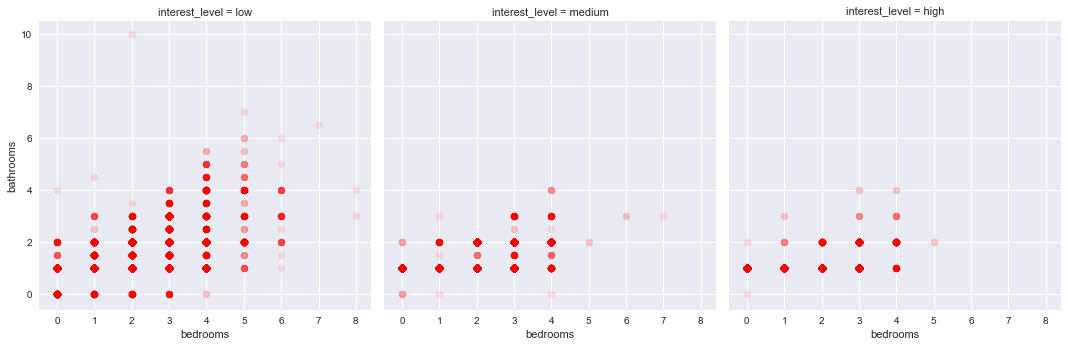

In [16]:
g = sns.FacetGrid(train_df,
                  col="interest_level",
                  size=5,
                  palette="husl",
                  col_order =['low','medium','high'])
g = g.map(plt.scatter, "bedrooms", "bathrooms",
          alpha=0.1,
          color="red")
plt.show()

Low interest tend to have more bedrooms and bathrooms that high and medium which are pretty similar.

## bedroom/bathroom ratio

We also want to explore the ration between bedrooms and bathrooms

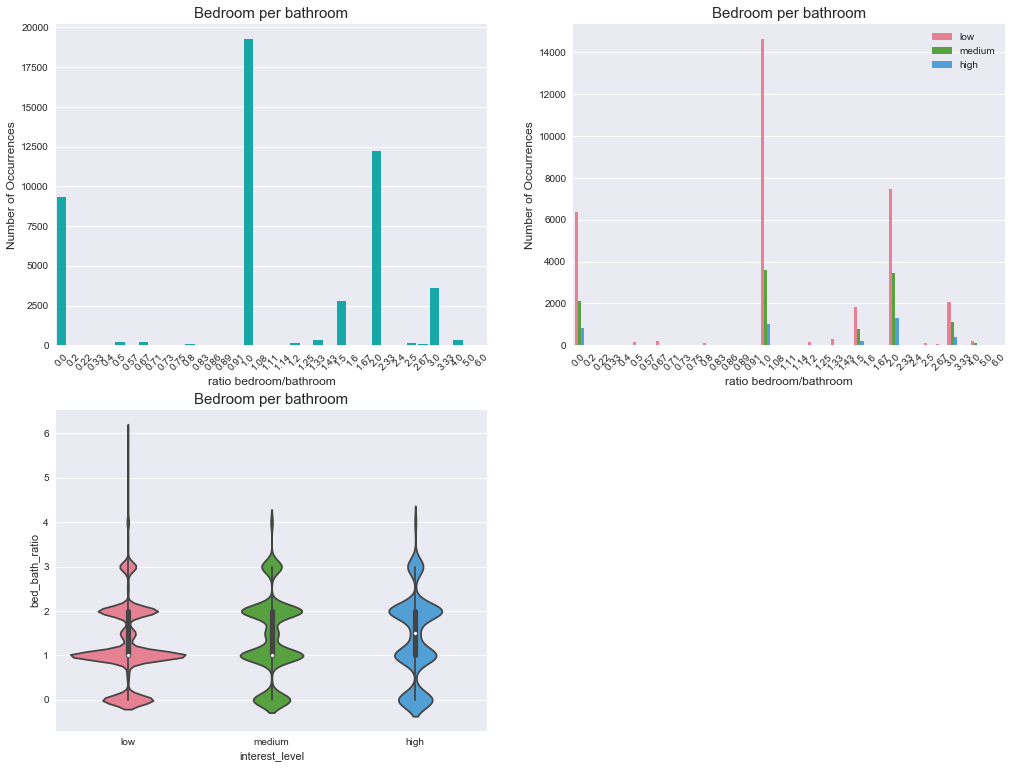

In [17]:
train_df["bed_bath_ratio"] = ((train_df["bedrooms"]) / (train_df["bathrooms"])).round(2)

ratio_df = train_df[train_df["bed_bath_ratio"]<1000]

fig = plt.figure(figsize=(17,13))
# hist
fig.add_subplot(221)
a = sns.countplot(x='bed_bath_ratio', data=ratio_df, color="c")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('ratio bedroom/bathroom', fontsize=12)
plt.title("Bedroom per bathroom",fontsize=15)
plt.xticks(rotation=45)
# hist hue
fig.add_subplot(222)
sns.countplot(x='bed_bath_ratio',
              hue='interest_level',
              data=ratio_df,
              palette="husl",
              hue_order =['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('ratio bedroom/bathroom', fontsize=12)
plt.title("Bedroom per bathroom",fontsize=15)
plt.legend(loc='upper right')
plt.xticks(rotation=45)
# violin
fig.add_subplot(223)
sns.violinplot(y='bed_bath_ratio',
               x='interest_level', 
               data=ratio_df,
               palette="husl",
               order =['low','medium','high'])
plt.title("Bedroom per bathroom",fontsize=15)

plt.show()

del ratio_df

Most listings have ratio 1, which is also the most common for low interest listings. High interest listings have ratio 2 more often.

## building_id	

How many `building_id` total? how many unique? how many with no `building_id`?

In [18]:
print("Total buildings: %s out of %s total listings"
      %(train_df.building_id.value_counts().shape[0],train_df.building_id.shape[0]))
print("Listings with no building: %s" %train_df.building_id.value_counts()[0])

Total buildings: 7585 out of 49352 total listings
Listings with no building: 8286


## created

Let's extract year, month, day, weekday, hour, and min

In [19]:
train_df.created = pd.to_datetime(train_df.created)
train_df["year"] = train_df["created"].dt.year
train_df["day"] = train_df["created"].dt.day
train_df["month"] = train_df["created"].dt.month
train_df["hour"] = train_df["created"].dt.hour
train_df["min"] = train_df["created"].dt.minute
train_df["weekday"] = train_df["created"].dt.weekday
train_df[["created","year","month","day","hour","min","weekday"]].head()

,created,year,month,day,hour,min,weekday
10,2016-06-24 07:54:24,2016,6,24,7,54,4
10000,2016-06-12 12:19:27,2016,6,12,12,19,6
100004,2016-04-17 03:26:41,2016,4,17,3,26,6
100007,2016-04-18 02:22:02,2016,4,18,2,22,0
100013,2016-04-28 01:32:41,2016,4,28,1,32,3


In [20]:
train_df["year"].value_counts()

2016    49352
Name: year, dtype: int64

There is only one year so we don't need to use it.

Let's explore month, day, and weekday.

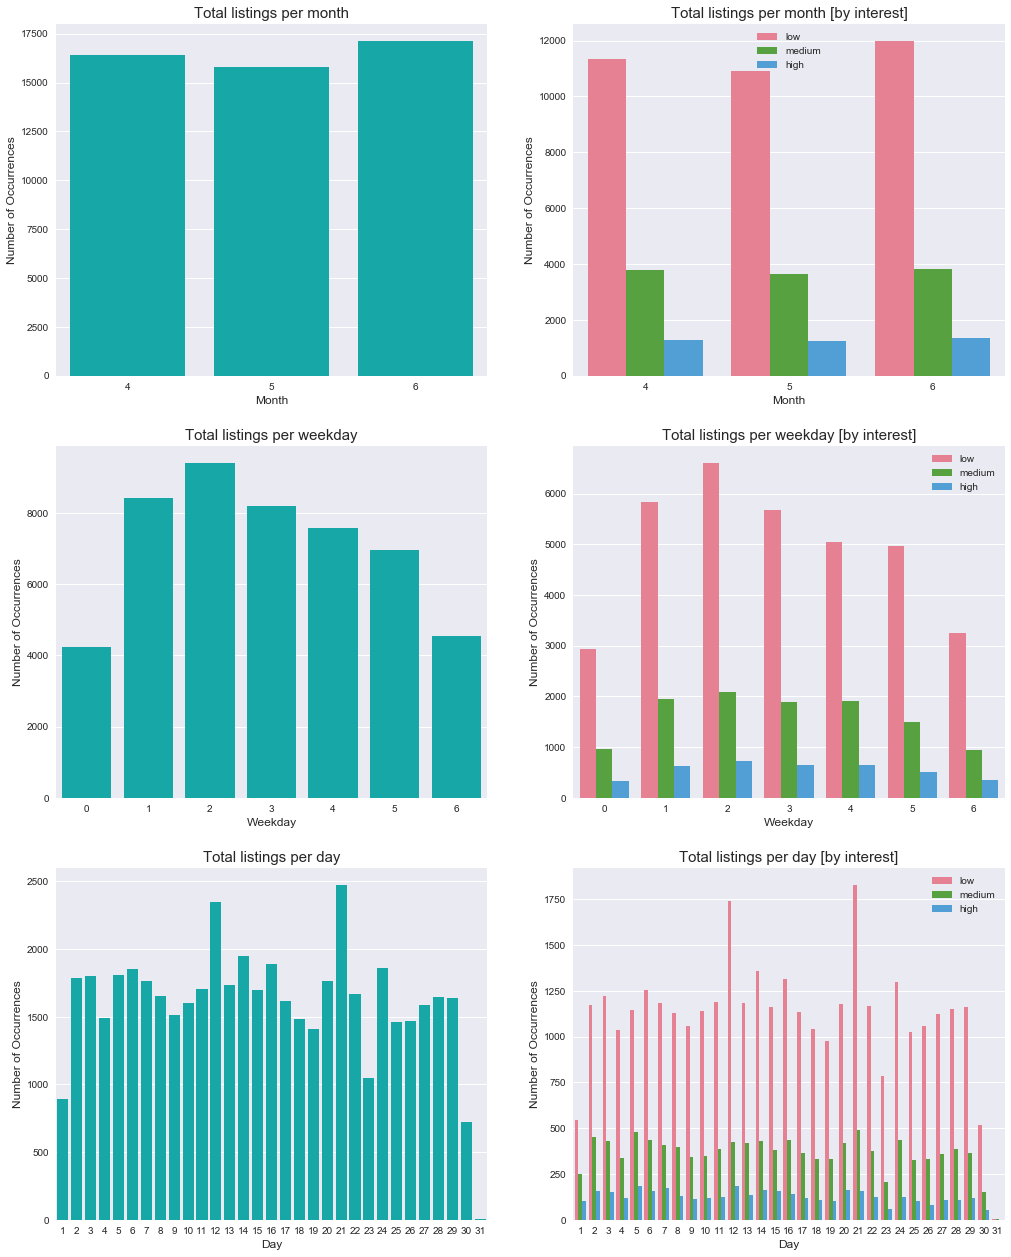

In [21]:
fig = plt.figure(figsize=(17,22))
# hist
fig.add_subplot(321)
sns.countplot(x='month',
              data=train_df,
              color="c")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title("Total listings per month",fontsize=15)
# hist hue
fig.add_subplot(322)
sns.countplot(x='month',
              hue='interest_level',
              data=train_df,
              palette="husl",
              hue_order =['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.title("Total listings per month [by interest]",fontsize=15)
plt.legend(loc='upper center')

# hist
fig.add_subplot(323)
sns.countplot(x='weekday', data=train_df, color="c")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Weekday', fontsize=12)
plt.title("Total listings per weekday",fontsize=15)
# hist hue
fig.add_subplot(324)
sns.countplot(x='weekday',
              hue='interest_level',
              data=train_df, 
              palette="husl", 
              hue_order =['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Weekday', fontsize=12)
plt.title("Total listings per weekday [by interest]",fontsize=15)
plt.legend(loc='upper right')

# hist
fig.add_subplot(325)
sns.countplot(x='day', 
              data=train_df,
              color="c",
              hue_order =['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.title("Total listings per day",fontsize=15)
# hist hue
fig.add_subplot(326)
sns.countplot(x='day',
              hue='interest_level',
              data=train_df,
              palette="husl",
              hue_order =['low','medium','high'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Day', fontsize=12)
plt.title("Total listings per day [by interest]",fontsize=15)
plt.legend(loc='upper right')

plt.show()

As expected not much information can be extracted when we check the plots by interest. On the other hands we can see what days, months and weekdays were listings created.

## description

Here we'll apply some NLP techniques as:

* td-tdi
* count words
* count numbers

Some listings doesn't have description, how many? Let's visualize by interest

In [22]:
train_df["has_description"] = train_df.description.map(lambda x:
                                                       "Has description"
                                                       if x!="" else 
                                                       "NO description")
train_df["has_description"].value_counts()

Has description    47906
NO description      1446
Name: has_description, dtype: int64

Very few, let's check the listings with no description by interest

In [23]:
# does it have an address
train_df[train_df["has_description"] == "NO description"]["interest_level"].value_counts()

low       1331
medium      72
high        43
Name: interest_level, dtype: int64

The proportions look as expected

## display_address, latitude, and longitude 

Let's check the features and get some descriptive stats for latitude and longitude

In [24]:
train_df[["display_address","latitude","longitude"]].head()

,display_address,latitude,longitude
10,Metropolitan Avenue,40.7145,-73.9425
10000,Columbus Avenue,40.7947,-73.9667
100004,W 13 Street,40.7388,-74.0018
100007,East 49th Street,40.7539,-73.9677
100013,West 143rd Street,40.8241,-73.9493


In [25]:
train_df[["latitude","longitude"]].describe()

,latitude,longitude
count,49352.000000,49352.000000
mean,40.741545,-73.955716
std,0.638535,1.177912
min,0.000000,-118.271000
25%,40.728300,-73.991700
50%,40.751800,-73.977900
75%,40.774300,-73.954800
max,44.883500,0.000000


This is NYC, thus, some values don't seem right. We'll need to fix them. Let's check some:

In [26]:
train_df.latitude.value_counts().sort_index().iloc[:10]

0.0000     12
34.0126     1
39.7996     1
39.8395     1
40.0450     1
40.1159     1
40.5065     4
40.5494     1
40.5712     1
40.5757     4
Name: latitude, dtype: int64

In [27]:
train_df.longitude.value_counts().sort_index().iloc[:10]

-118.2710    1
-93.2705     1
-87.6134     1
-86.1527     1
-76.6336     1
-75.5214     1
-75.1773     1
-74.6637     1
-74.6267     1
-74.6248     1
Name: longitude, dtype: int64

To finish with this features let's visualize all listings in the map. First map shows all listings and second all listings by interest

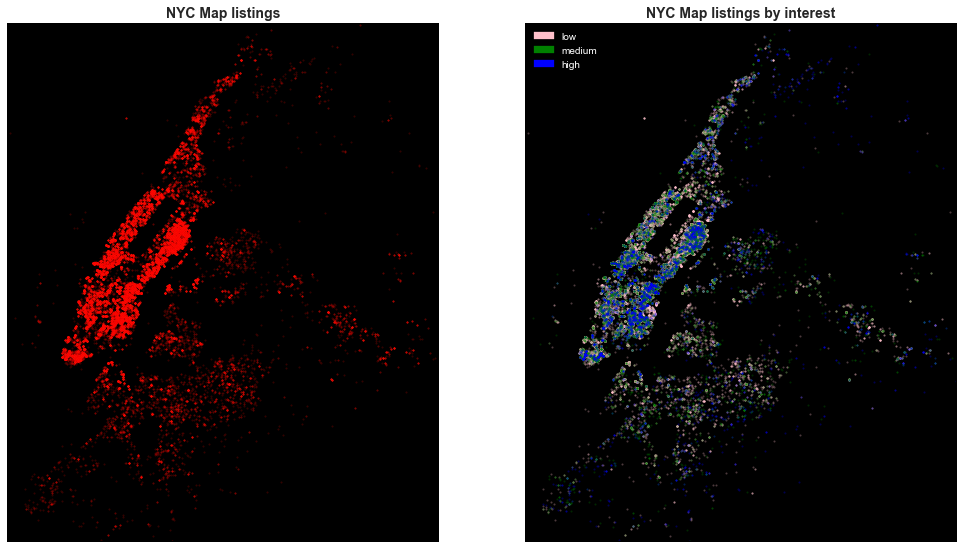

In [28]:
from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches

west, south, east, north = -74.05, 40.60, -73.80, 40.90
low = train_df[train_df["interest_level"] == "low"]
medium = train_df[train_df["interest_level"] == "medium"]
high = train_df[train_df["interest_level"] == "high"]

fig = plt.figure(figsize=(17,22))

fig.add_subplot(221)
m = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west,
            urcrnrlon=east, lat_ts=south,resolution='i')

m.plot(train_df['longitude'].values,train_df['latitude'].values,
       'bo', 
       markersize=2,
       color='red',
       alpha=0.2,
       markeredgecolor='yellow',
       markeredgewidth=0.05) 
m.drawmapboundary(fill_color='black')

plt.title("NYC Map listings",fontweight = 'bold', size=14)

fig.add_subplot(222)
m = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west,
            urcrnrlon=east, lat_ts=south,resolution='i')

m.plot(low['longitude'].values,low['latitude'].values,
       'bo', 
       markersize=2, color='pink',alpha=0.3,
       markeredgewidth=0.05) 
m.plot(medium['longitude'].values,medium['latitude'].values,
       'bo', 
       markersize=2, color='green',alpha=0.3, 
       markeredgewidth=0.05) 
m.plot(high['longitude'].values,high['latitude'].values,
       'bo', 
       markersize=2, color='blue',alpha=0.3, 
       markeredgewidth=0.05) 
m.drawmapboundary(fill_color='black')

#legend
pink_patch = mpatches.Patch(color='pink', label='low')
green_patch = mpatches.Patch(color='green', label='medium')
blue_patch = mpatches.Patch(color='blue', label='high')
l = plt.legend(handles=[pink_patch,green_patch,blue_patch])
for text in l.get_texts():
    text.set_color("white")

plt.title("NYC Map listings by interest",fontweight = 'bold', size=14)
plt.show()

#extracts of this code were taken from:
#https://www.kaggle.com/sudalairajkumar/two-sigma-connect-rental-listing-inquiries/simple-exploration-notebook-2-connect
#thanks https://www.kaggle.com/sudalairajkumar !!

It looks like most "high interest" listings are in the east side of Manhattan

Let's check which listings have address and if that affects the interest

In [29]:
train_df["has_address"] = train_df.display_address.map(lambda x: 1 if x!="" else 0)
print("No address:")
print(train_df[train_df["has_address"] == 0]["interest_level"].value_counts())
print("\nAddress:")
print(train_df[train_df["has_address"] == 1]["interest_level"].value_counts())

No address:
low       88
medium    27
high      20
Name: interest_level, dtype: int64

Address:
low       34196
medium    11202
high       3819
Name: interest_level, dtype: int64


## features

Let's find out:

* Number of unique features
* Plot top 20 features of of each interest level

Number of unique features: 1556


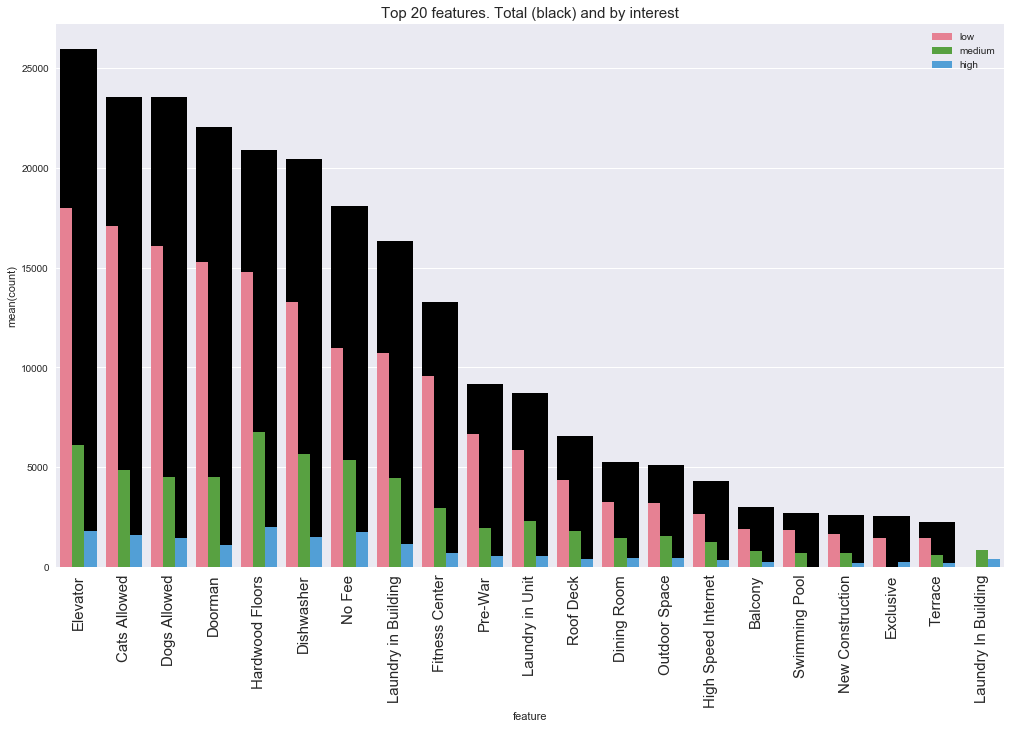

In [30]:
from collections import Counter

# unique features
features_unique = list(set([i for list_features in train_df.features.tolist() for i in list_features]))
# top 20 
features = [i for list_features in train_df.features.tolist() for i in list_features]
print("Number of unique features: %s" %len(features_unique))

c = Counter(features)
features20_df = pd.DataFrame(c.most_common(20), columns=["feature","count"])

# top 20 per interest
features_interest_df = []

for interest in ["low", "medium", "high"]:
    features = [i for list_features in train_df[train_df["interest_level"] == interest].features.tolist() 
                for i in list_features]
    c = Counter(features)
    aux_df = pd.DataFrame(c.most_common(20), columns=["feature","count"])
    aux_df["interest_level"] = interest
    features_interest_df.append(aux_df)

features_interest_df = pd.concat(features_interest_df)

#plot
fig = plt.figure(figsize=(17,10))

sns.barplot(x='feature', y='count', data=features20_df, color="black")
plt.title("Top 20 features. Total (black) and by interest",fontsize=15)
sns.barplot(x='feature',
            y='count', 
            hue='interest_level',
            data=features_interest_df,
            palette="husl")
plt.legend(loc='upper right')
plt.xticks(rotation=90, size=15)

plt.show()

Most of the features are common for all interests except for "Laundry in the building" which only shows up in medium and high.

Does having features have any impact? What about the number?

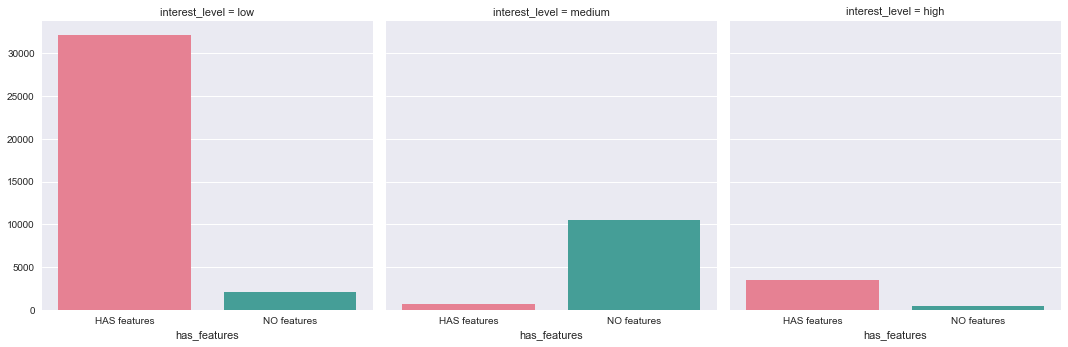

In [31]:
train_df["has_features"] = train_df.features.map(lambda x: "HAS features" 
                                                 if x !=[] 
                                                 else "NO features")
g = sns.FacetGrid(train_df, 
                  col="interest_level",
                  size=5,
                  col_order =['low','medium','high'])
g = g.map(sns.countplot, "has_features",palette="husl")
plt.show()

Having features doesn't seem to spike interest. Most of low interest listings have features. On the other hand medium has many more listings with no features and high has closer numbers. Let's also check the distribution of the features by interest

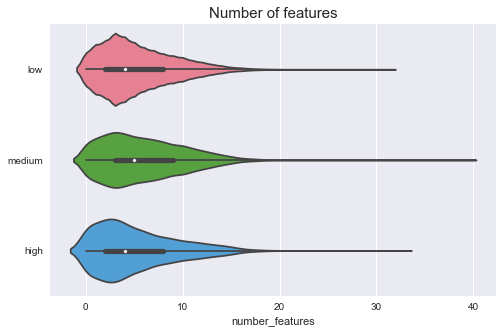

In [32]:
fig = plt.figure(figsize=(8,5))
train_df["number_features"] = train_df.features.map(lambda x: len(x))
sns.violinplot(x='number_features',
               y='interest_level',
               data=train_df,
               palette="husl",
               order =['low','medium','high'])
plt.title("Number of features",fontsize=15)
plt.ylabel("")
plt.show()

## manager_id

How many `manager_id` total? how many unique? how many with no `manager_id`?

In [33]:
print("Total managers: %s out of %s total listings"
      %(train_df.manager_id.value_counts().shape[0],train_df.manager_id.shape[0]))
print("Listings with no manager: %s" %train_df.manager_id.value_counts()[0])

Total managers: 3481 out of 49352 total listings
Listings with no manager: 2533


## photos

Is it important having photos for the interest?

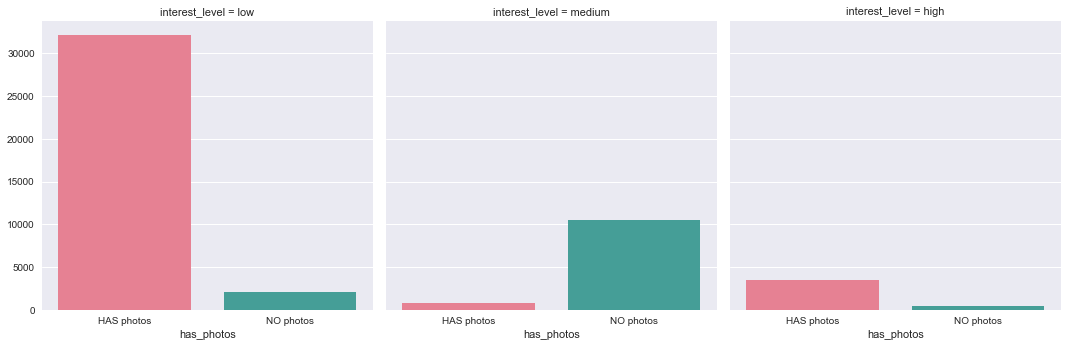

In [34]:
# has photos or not
train_df["has_photos"] = train_df.features.map(lambda x: "HAS photos" if x !=[] else "NO photos")

g = sns.FacetGrid(train_df,
                  col="interest_level",
                  size=5,
                  col_order =['low','medium','high'])
g = g.map(sns.countplot,
          "has_photos",
          palette="husl")
plt.show()

It seems it is! But not they way I expected, having photos doesn't attract users, maybe better no photos than crappy photos. Let's chek the distrution of number of photos

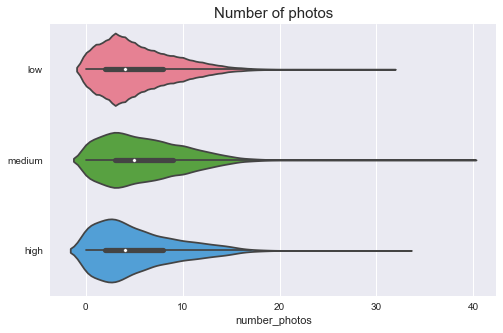

In [35]:
#number of photos
train_df["number_photos"] = train_df.features.map(lambda x: len(x))
fig = plt.figure(figsize=(8,5))
sns.violinplot(x='number_photos', y='interest_level', data=train_df,
               palette="husl", order =['low','medium','high'])
plt.title("Number of photos",fontsize=15)
plt.ylabel("")
plt.show()

## price       

Some stats on price:

In [36]:
train_df.price.describe()

count    4.935200e+04
mean     3.830174e+03
std      2.206687e+04
min      4.300000e+01
25%      2.500000e+03
50%      3.150000e+03
75%      4.100000e+03
max      4.490000e+06
Name: price, dtype: float64

We have some very low values and high we'll need to check

In [37]:
train_df.price.value_counts().sort_index()[:5]

43     1
45     1
401    1
695    4
700    1
Name: price, dtype: int64

In [38]:
train_df.price.value_counts().sort_index()[-5:]

111111     1
135000     1
1070000    2
1150000    1
4490000    1
Name: price, dtype: int64

Let's check the distribution on prices by interest

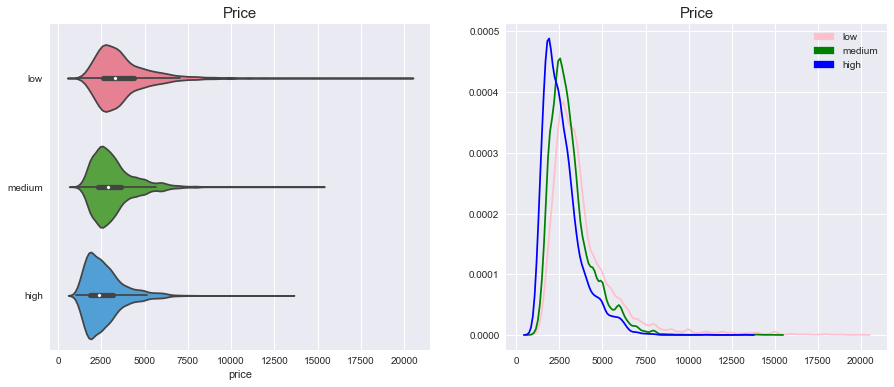

In [39]:
fig = plt.figure(figsize=(15,6))

fig.add_subplot(121)

#filter outliers
price_df = train_df[(train_df["price"]<20000) &
                    (train_df["price"]>1000)][["price", "bathrooms", "bedrooms","interest_level"]] #zoom
sns.violinplot(x='price',
               y='interest_level',
               data=price_df,
               palette="husl",
               order =['low','medium','high'])
plt.title("Price",fontsize=15)
plt.ylabel("")

fig.add_subplot(122)

sns.kdeplot(price_df[price_df["interest_level"]=='low']["price"],
            color="pink")
sns.kdeplot(price_df[price_df["interest_level"]=='medium']["price"],
            color="green")
sns.kdeplot(price_df[price_df["interest_level"]=='high']["price"],
            color="blue")
plt.title("Price",fontsize=15)

#legend
pink_patch = mpatches.Patch(color='pink', label='low')
green_patch = mpatches.Patch(color='green', label='medium')
blue_patch = mpatches.Patch(color='blue', label='high')
plt.legend(handles=[pink_patch,green_patch,blue_patch])


plt.show()

Let's check if price and the number of bedrooms and bathrooms are correlated

In [40]:
corr = price_df[["bathrooms","bedrooms","price"]].corr()
print(corr)

           bathrooms  bedrooms     price
bathrooms   1.000000  0.527931  0.691795
bedrooms    0.527931  1.000000  0.526876
price       0.691795  0.526876  1.000000


They are (at least a little), let plot price against bedrooms and bathrooms

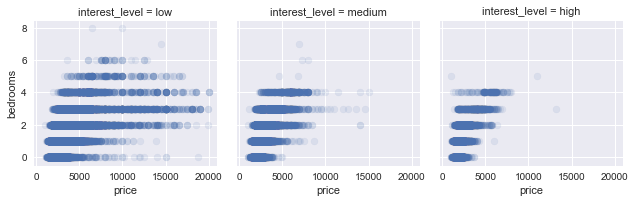

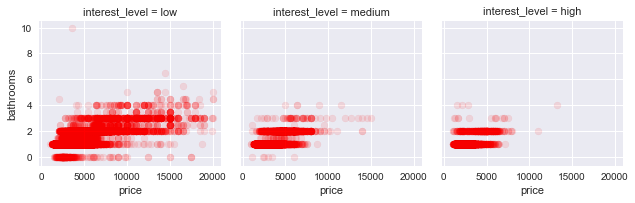

In [41]:
g = sns.FacetGrid(price_df,
                  col="interest_level",
                  col_order =['low','medium','high'])  
g.map(plt.scatter,
      "price",
      "bedrooms",
      alpha=0.1)  
g = sns.FacetGrid(price_df,
                  col="interest_level",
                  col_order =['low','medium','high'])  
g.map(plt.scatter,
      "price",
      "bathrooms", 
      color='red',
      alpha=0.1)  
plt.show()

## street_address

Shows more detail than `display_address` as we can see below

In [42]:
train_df[["street_address","display_address"]].head(10)

,street_address,display_address
10,792 Metropolitan Avenue,Metropolitan Avenue
10000,808 Columbus Avenue,Columbus Avenue
100004,241 W 13 Street,W 13 Street
100007,333 East 49th Street,East 49th Street
100013,500 West 143rd Street,West 143rd Street
100014,350 West 18th Street,West 18th Street
100016,210 West 107th Street,West 107th Street
100020,155 West 21st Street,West 21st Street
100026,63 Hamilton Terrace,Hamilton Terrace
100027,522 E 11th,522 E 11th


### Some takeaways:

* Oversampling
* Account for half bathrooms
* Account for bathrooms == 0 (from description? features?)
* Outliers in bathrooms? (more than 5)
* Account for bedrooms == 0 (from description? features?) 
* ration and sum
* drop street address
* get NYC zone from address
* one-hot for features
* fix weired features
* yes/no features columns
* number of features
* outliers in price

### END